In [22]:
import os
import cv2
import numpy as np
import mediapipe as mp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

In [23]:
DATASET_DIR = "ASL_Alphabet/train"    # use ONLY train folder
OUTPUT_DIR = "keypoints_dataset"

os.makedirs(OUTPUT_DIR, exist_ok=True)


In [24]:
mp_holistic = mp.solutions.holistic

def extract_hand_keypoints(image):
    with mp_holistic.Holistic(static_image_mode=True) as holistic:
        results = holistic.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        hand = None
        if results.right_hand_landmarks:
            hand = results.right_hand_landmarks.landmark
        elif results.left_hand_landmarks:
            hand = results.left_hand_landmarks.landmark
        else:
            return None

        pts = np.array([[lm.x, lm.y, lm.z] for lm in hand], dtype=np.float32)
        return pts.flatten()  # 63 features


In [6]:
for label in os.listdir(DATASET_DIR):
    label_path = os.path.join(DATASET_DIR, label)
    if not os.path.isdir(label_path):
        continue

    save_label_dir = os.path.join(OUTPUT_DIR, label)
    os.makedirs(save_label_dir, exist_ok=True)

    print(f"Processing {label}...")

    for idx, file in enumerate(os.listdir(label_path)):
        img_path = os.path.join(label_path, file)

        # output filename
        out_file = f"{label}_{idx:04d}.npy"
        save_path = os.path.join(save_label_dir, out_file)

        # ⭐ SKIP if file already processed
        if os.path.exists(save_path):
            continue

        image = cv2.imread(img_path)
        if image is None:
            print(f"[SKIPPED: cannot load] {img_path}")
            continue

        keypoints = extract_hand_keypoints(image)
        if keypoints is None:
            print(f"[SKIPPED: no hand] {img_path}")
            continue

        np.save(save_path, keypoints)

    print(f"✔ Done: {label}")


Processing A...
[SKIPPED: no hand] ASL_Alphabet/train\A\1.jpg
[SKIPPED: no hand] ASL_Alphabet/train\A\11.jpg
[SKIPPED: no hand] ASL_Alphabet/train\A\12.jpg
[SKIPPED: no hand] ASL_Alphabet/train\A\13.jpg
[SKIPPED: no hand] ASL_Alphabet/train\A\14.jpg
[SKIPPED: no hand] ASL_Alphabet/train\A\145.jpg
[SKIPPED: no hand] ASL_Alphabet/train\A\146.jpg
[SKIPPED: no hand] ASL_Alphabet/train\A\147.jpg
[SKIPPED: no hand] ASL_Alphabet/train\A\148.jpg
[SKIPPED: no hand] ASL_Alphabet/train\A\149.jpg
[SKIPPED: no hand] ASL_Alphabet/train\A\15.jpg
[SKIPPED: no hand] ASL_Alphabet/train\A\150.jpg
[SKIPPED: no hand] ASL_Alphabet/train\A\151.jpg
[SKIPPED: no hand] ASL_Alphabet/train\A\152.jpg
[SKIPPED: no hand] ASL_Alphabet/train\A\153.jpg
[SKIPPED: no hand] ASL_Alphabet/train\A\154.jpg
[SKIPPED: no hand] ASL_Alphabet/train\A\155.jpg
[SKIPPED: no hand] ASL_Alphabet/train\A\156.jpg
[SKIPPED: no hand] ASL_Alphabet/train\A\157.jpg
[SKIPPED: no hand] ASL_Alphabet/train\A\158.jpg
[SKIPPED: no hand] ASL_Alphabet

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# MediaPipe hand connections (21 points)
connections = [
    (0,1), (1,2), (2,3), (3,4),       # Thumb
    (0,5), (5,6), (6,7), (7,8),       # Index
    (0,9), (9,10), (10,11), (11,12),  # Middle
    (0,13), (13,14), (14,15), (15,16),# Ring
    (0,17), (17,18), (18,19), (19,20) # Pinky
]

def show_keypoints_white(npy_path, title="Keypoint Visualization"):
    """Visualize hand keypoints from .npy file on a white background."""

    # Load keypoints
    kp = np.load(npy_path).reshape(21, 3)

    # Extract x,y only
    x = kp[:, 0]
    y = kp[:, 1]

    # Normalize so the hand fits nicely inside the plot
    x = (x - x.min()) / (x.max() - x.min())
    y = (y - y.min()) / (y.max() - y.min())

    # Flip Y-axis to make it look natural
    y = 1 - y

    plt.figure(figsize=(5,5))
    plt.title(title)

    # White background
    plt.gca().set_facecolor("white")

    # Draw connections
    for a, b in connections:
        plt.plot([x[a], x[b]], [y[a], y[b]], color="black", linewidth=2)

    # Draw keypoints
    plt.scatter(x, y, color="red", s=50)

    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.axis("off")
    plt.show()


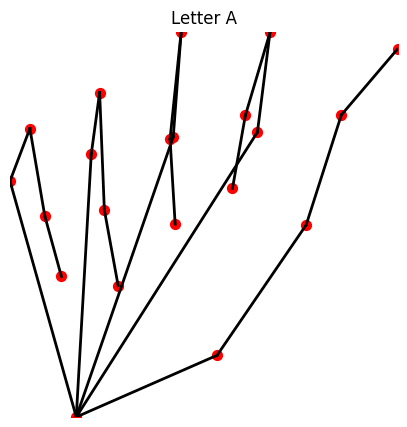

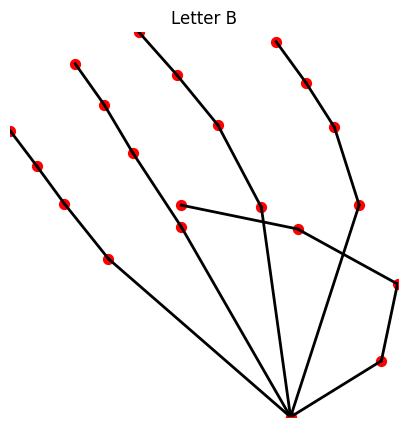

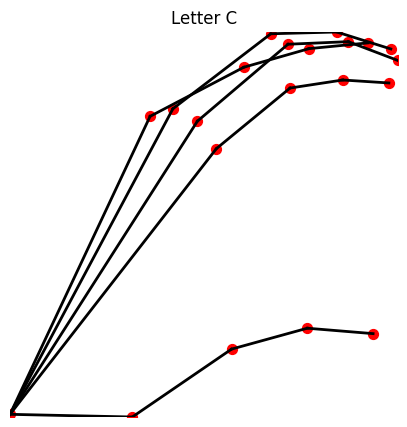

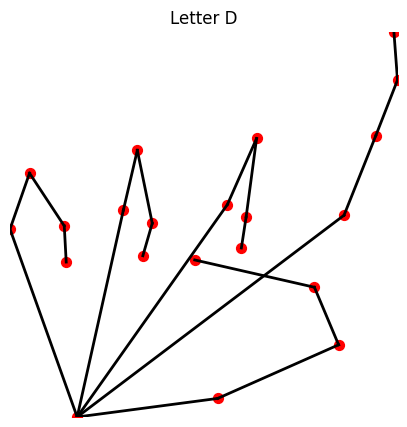

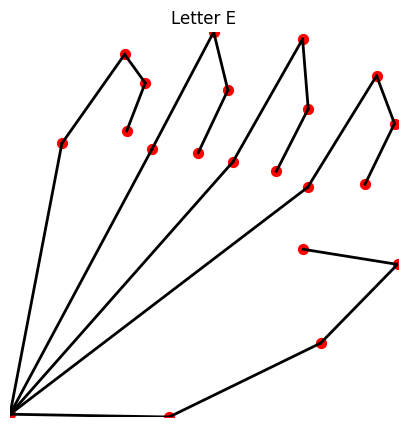

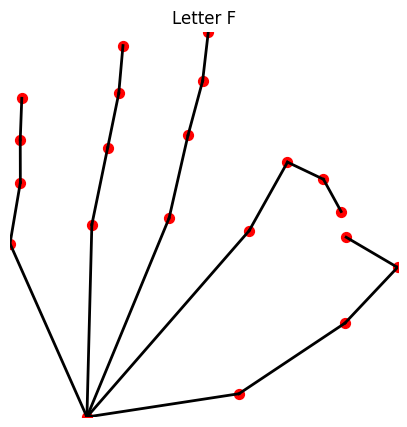

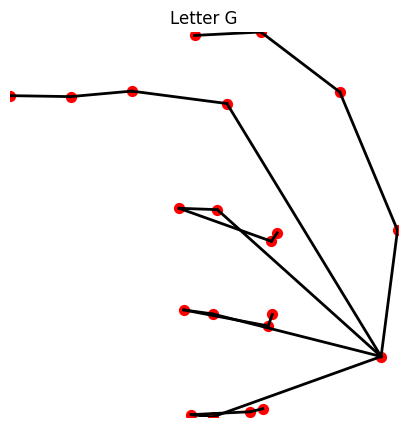

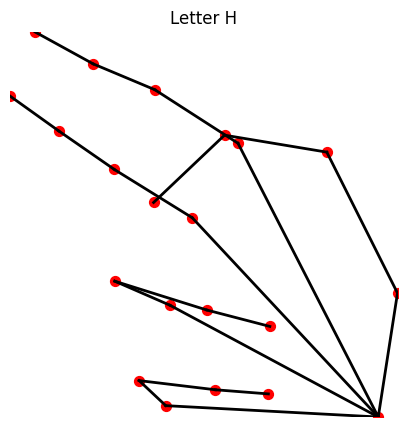

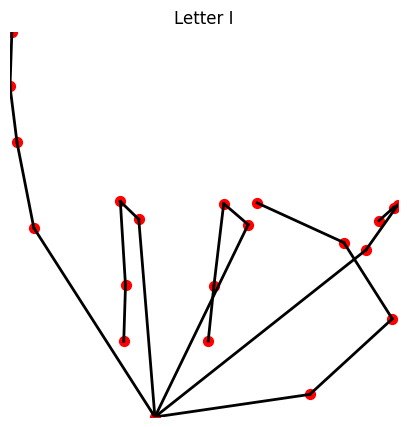

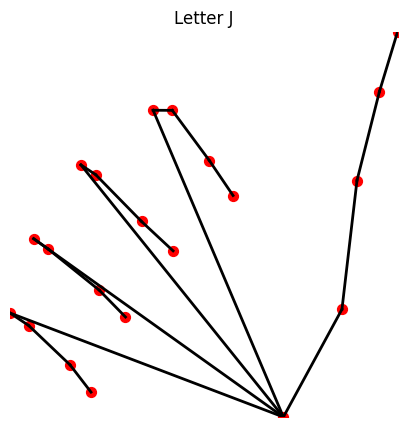

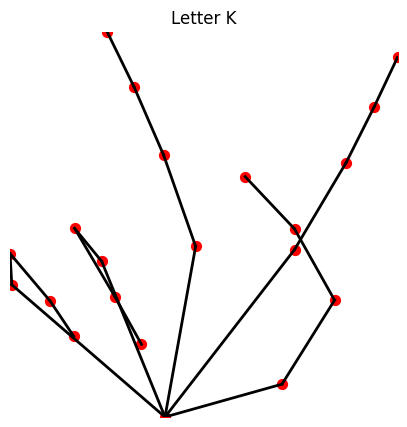

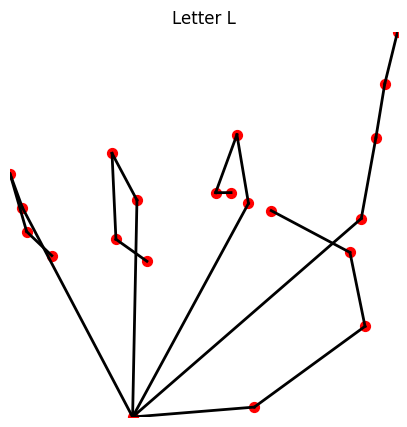

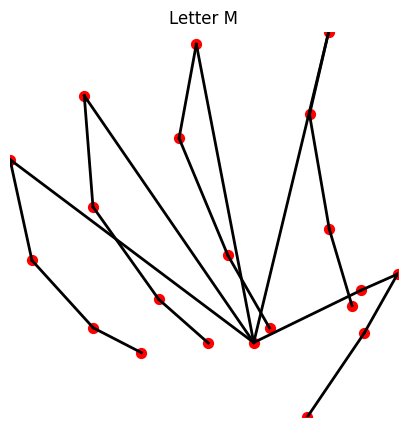

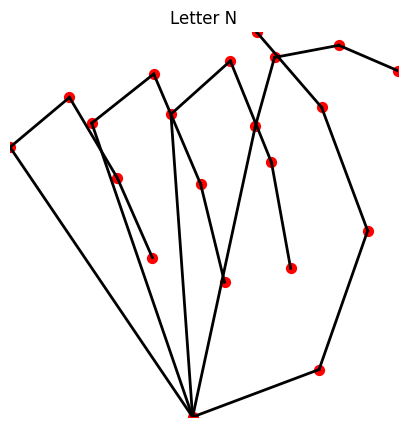

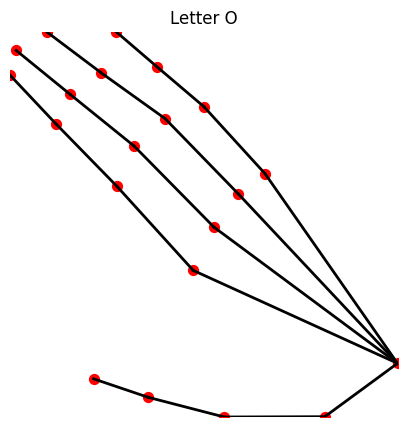

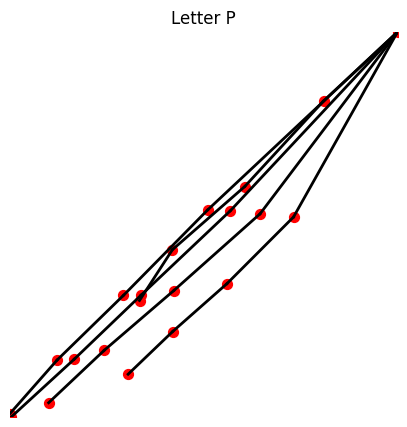

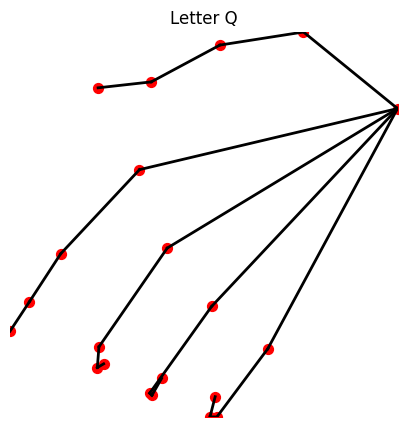

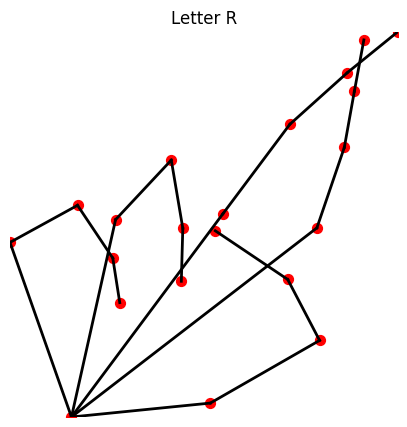

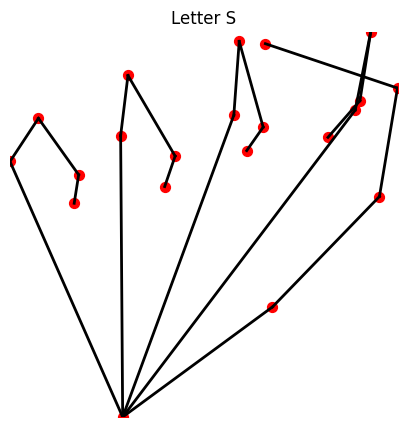

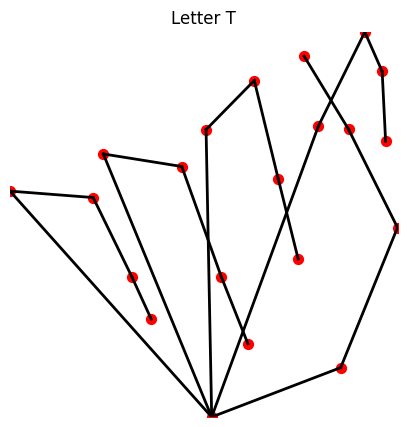

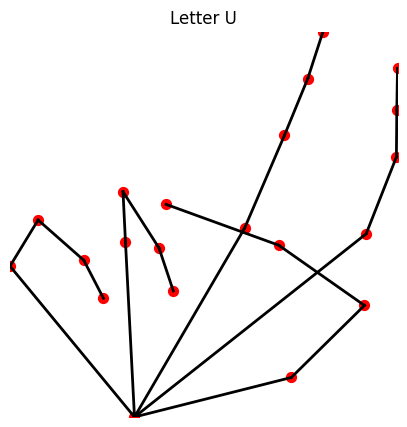

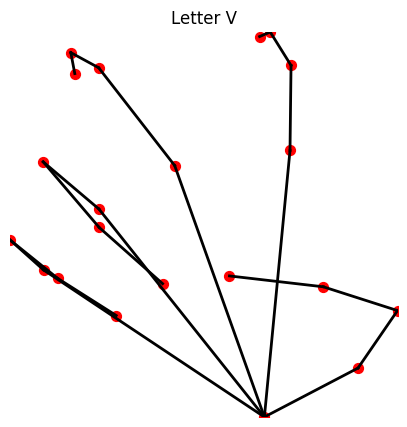

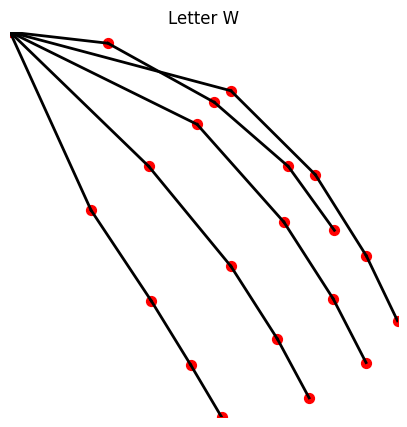

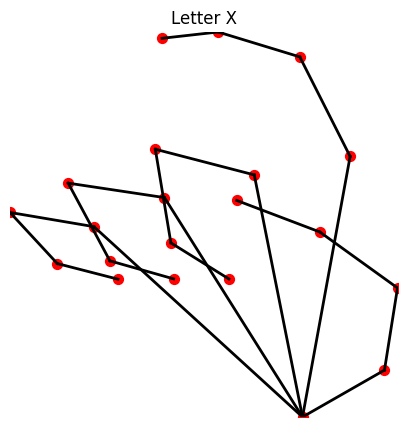

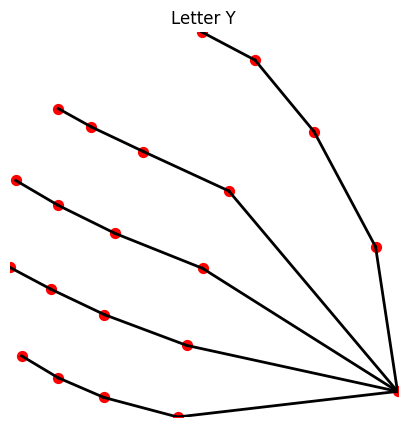

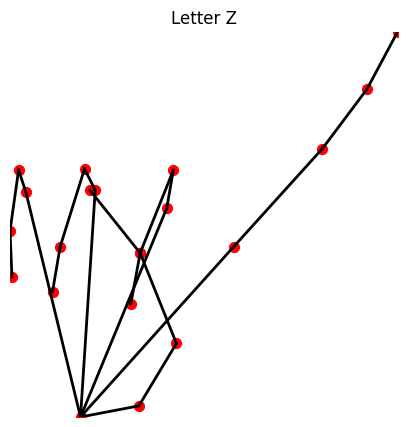

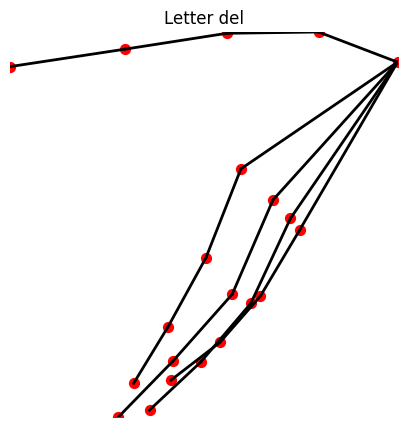

No .npy files in keypoints_dataset\nothing


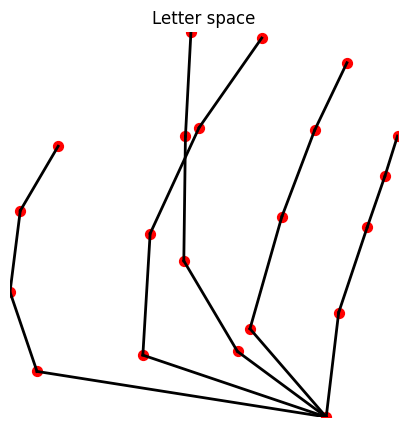

In [26]:
BASE = "keypoints_dataset"

for label in sorted(os.listdir(BASE)):
    label_dir = os.path.join(BASE, label)
    if not os.path.isdir(label_dir):
        continue

    # Filter only .npy files
    files = [f for f in os.listdir(label_dir) if f.endswith(".npy")]
    if len(files) == 0:
        print(f"No .npy files in {label_dir}")
        continue

    sample_file = os.path.join(label_dir, files[0])
    show_keypoints_white(sample_file, f"Letter {label}")


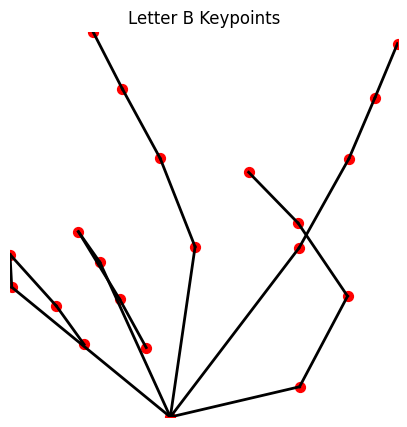

In [27]:
show_keypoints_white("keypoints_dataset/K/K_0036.npy", "Letter B Keypoints")


In [28]:
X, y = [], []

for label in os.listdir(OUTPUT_DIR):
    label_dir = os.path.join(OUTPUT_DIR, label)

    for f in os.listdir(label_dir):
        if f.endswith(".npy"):
            arr = np.load(os.path.join(label_dir, f))
            X.append(arr)
            y.append(label)

X = np.array(X)
y = np.array(y)

print("Dataset shape:", X.shape, y.shape)

Dataset shape: (11796, 63) (11796,)


In [29]:
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=0.2,
    shuffle=True,
    stratify=y_encoded
)

print("Train:", X_train.shape)
print("Test:", X_test.shape)

Train: (9436, 63)
Test: (2360, 63)


In [30]:
def normalize_keypoints(kp):
    kp = kp.reshape(21, 3)
    
    # subtract wrist position (landmark 0)
    base = kp[0].copy()
    kp -= base
    
    # scale by max distance
    max_val = np.max(np.abs(kp))
    kp /= max_val

    return kp.flatten()


In [31]:
X = np.array([normalize_keypoints(k) for k in X])

In [32]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(63,)),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(len(encoder.classes_), activation="softmax")
])


model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 256)               16384     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 28)               

In [33]:
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping callback
early_stop = EarlyStopping(
    monitor='val_loss',        # what metric to monitor
    patience=5,                # stop if no improvement for 5 epochs
    restore_best_weights=True # load best model after stopping
)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=1000,          # higher number is fine because early stopping will halt it
    batch_size=32,
    callbacks=[early_stop]
)


Epoch 1/1000
236/236 [==============================] - 1s 2ms/step - loss: 3.1750 - accuracy: 0.0843 - val_loss: 2.9316 - val_accuracy: 0.1637
Epoch 2/1000
236/236 [==============================] - 0s 2ms/step - loss: 2.7617 - accuracy: 0.1936 - val_loss: 2.4558 - val_accuracy: 0.2876
Epoch 3/1000
236/236 [==============================] - 0s 2ms/step - loss: 2.4736 - accuracy: 0.2488 - val_loss: 2.2481 - val_accuracy: 0.3210
Epoch 4/1000
236/236 [==============================] - 0s 2ms/step - loss: 2.2794 - accuracy: 0.3027 - val_loss: 2.0788 - val_accuracy: 0.3766
Epoch 5/1000
236/236 [==============================] - 0s 2ms/step - loss: 2.1756 - accuracy: 0.3298 - val_loss: 2.0076 - val_accuracy: 0.3840
Epoch 6/1000
236/236 [==============================] - 0s 2ms/step - loss: 2.0876 - accuracy: 0.3516 - val_loss: 1.9634 - val_accuracy: 0.4216
Epoch 7/1000
236/236 [==============================] - 0s 2ms/step - loss: 2.0208 - accuracy: 0.3745 - val_loss: 1.8366 - val_accuracy:

In [21]:
loss, acc = model.evaluate(X_test, y_test)
print("Test Accuracy:", acc)


73/73 [==============================] - 0s 655us/step - loss: 1.0878 - accuracy: 0.6800
Test Accuracy: 0.6799653172492981


In [46]:
# Save as .keras (recommended modern format)
model.save("asl_alphabet_model.keras")

# Save as .h5 (legacy format)
model.save("asl_alphabet_model.h5")

# Save as TensorFlow SavedModel (new Keras 3 method)
model.export("asl_alphabet_model_tf")  # folder output

print("✔ All model formats saved successfully!")


INFO:tensorflow:Assets written to: asl_alphabet_model_tf\assets


INFO:tensorflow:Assets written to: asl_alphabet_model_tf\assets


Saved artifact at 'asl_alphabet_model_tf'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 63), dtype=tf.float32, name='keras_tensor_12')
Output Type:
  TensorSpec(shape=(None, 28), dtype=tf.float32, name=None)
Captures:
  2305767041040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2305767039888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2305767036816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2305697994064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2305697992912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2305697991376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2305697988688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2305697992528: TensorSpec(shape=(), dtype=tf.resource, name=None)
✔ All model formats saved successfully!


In [47]:
np.save("alphabet_labels.npy", encoder.classes_)


In [1]:
import keras
print(keras.__version__)

3.11.1


In [2]:
import tensorflow as tf
print(tf.__version__)

2.20.0
